# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive
%cd ANDL_HOMEWORK2_LINK


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive
/gdrive/.shortcut-targets-by-id/1vsTygZGT_kAzNeU8X79sw_R-6RcOwzqm/Homework 2


## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

seed =42
# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings

import logging

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
import pandas as pd
import random
import tensorflow as tf

from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import layers, models as tfkl
np.random.seed(42)
tf.random.set_seed(42)
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

import albumentations as A
from albumentations.core.composition import Compose
import cv2


# from tensorflow.keras import mixed_precision
#
# # Enable mixed precision training
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")



# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)




[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


## ⏳ Load the Data

In [ ]:
# Load the NPZ file
#data = np.load("dataset/mars_for_students.npz")
#print("Labels in the NPZ file:", data.files)
#training_set = data["training_set"]
#X_train = training_set[:, 0]
#y_train = training_set[:, 1]
#X_test = data["test_set"]

training_set = np.load("dataset/cleaned_training_dataset.npz")
# Print the labels (keys)
print("Labels in the NPZ file:", training_set.files)

X_train = training_set["images"]
y_train = training_set["labels"]

X_testdata = np.load("dataset/test_dataset.npz")
# Print the labels (keys)
print("Labels in the NPZ file:", X_testdata.files)

X_test = X_testdata["images"]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

Labels in the NPZ file: ['images', 'labels']
Labels in the NPZ file: ['images']
X_train shape: (2505, 64, 128)
y_train shape: (2505, 64, 128)
X_test shape: (10022, 64, 128)


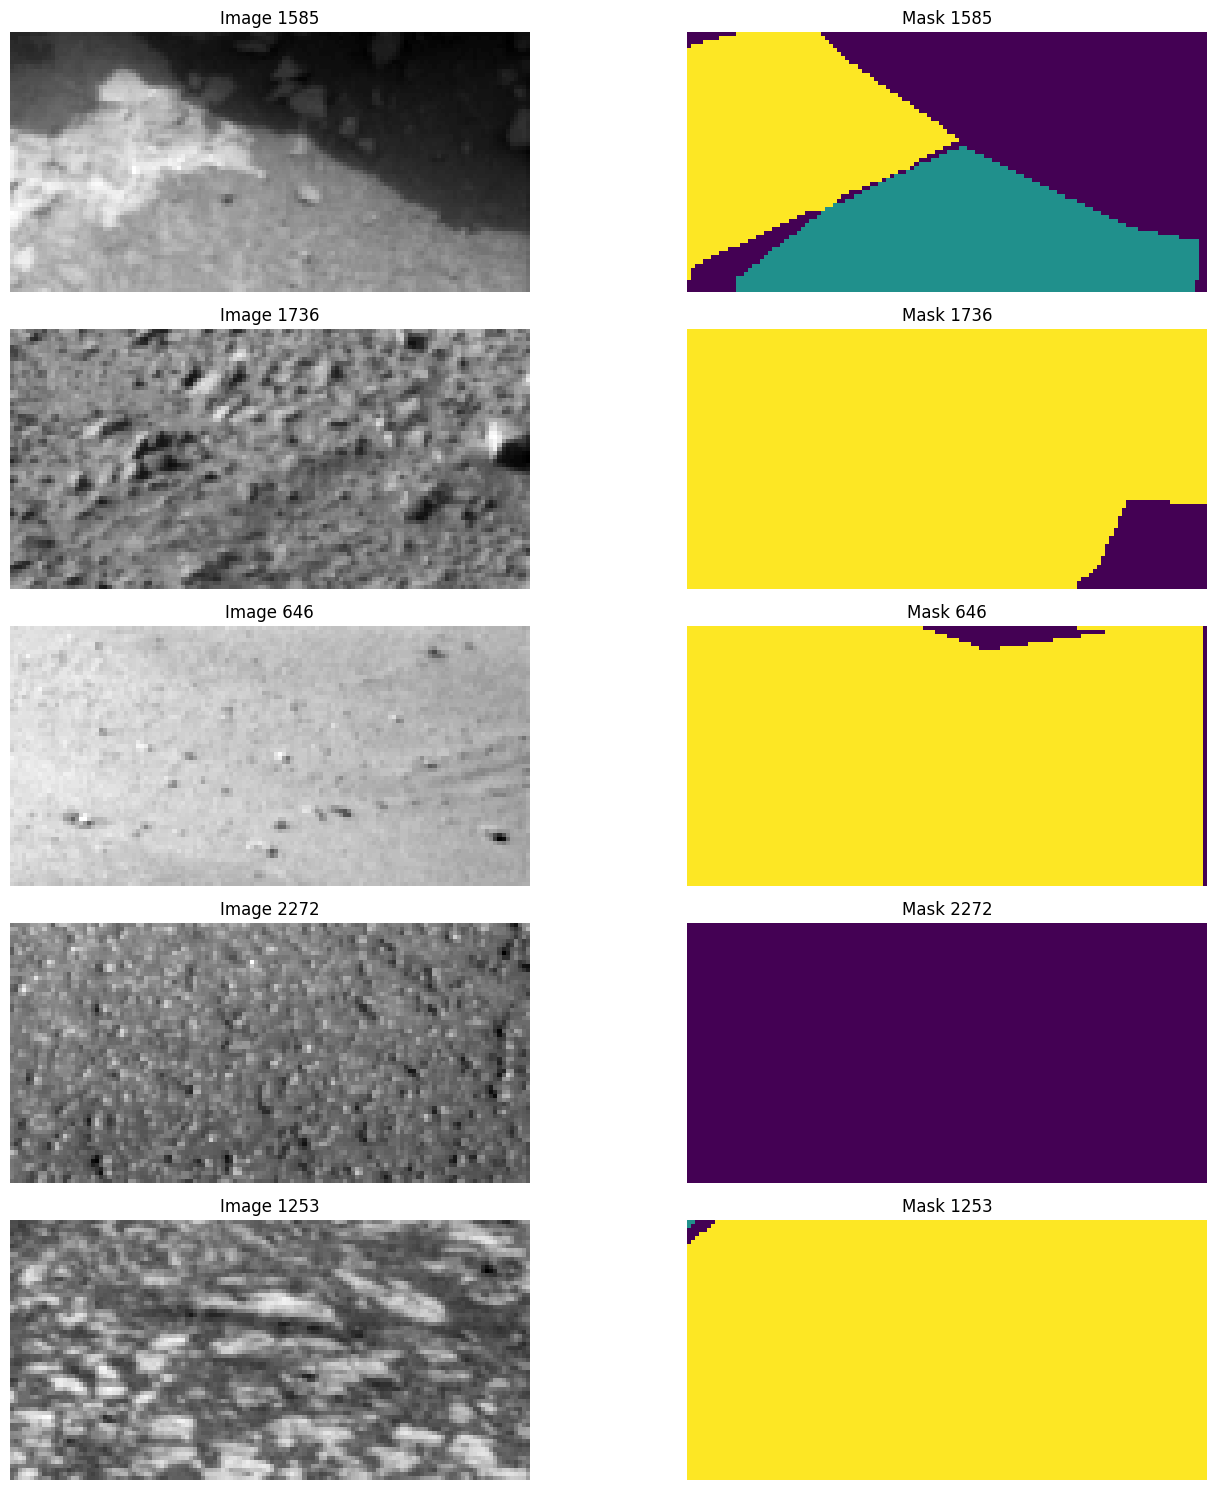

In [ ]:

# Function to plot images and masks
def plot_random_images(images, masks, num_images=5):
    # Select random indices for plotting
    indices = random.sample(range(len(images)), num_images)

    plt.figure(figsize=(15, num_images * 3))

    for i, idx in enumerate(indices):
        # Get the image and mask
        img = images[idx]
        mask = masks[idx]

        # Plot the image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(img, cmap='gray')  # Grayscale image
        plt.title(f"Image {idx}")
        plt.axis('off')

        # Plot the corresponding mask
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(mask, cmap='viridis')  # Use a color map for the mask
        plt.title(f"Mask {idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage with augmented images and masks
plot_random_images(X_train, y_train, num_images=5)


AUGMENTATIONS

In [ ]:

# Define the augmentations pipeline (without RandomCrop if image size is fixed)
augmentations = A.Compose([
    A.Rotate(limit=15, p=0.5),                        # Random rotation between -15 and 15 degrees
    A.HorizontalFlip(p=0.5),                          # Random horizontal flip
    A.VerticalFlip(p=0.5),                            # Random vertical flip
    A.RandomScale(scale_limit=0.2, p=0.5),            # Random zoom in/out by 20%
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),  # Elastic deformation
    A.RandomBrightnessContrast(p=0.5),                # Adjust brightness and contrast
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),      # Add Gaussian noise
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.3),  # Randomly cut out patches
])

# Function to apply augmentations and ensure consistent shapes
def apply_augmentation(image, mask):
    # Ensure the image and mask are in uint8 format
    image = image.astype(np.uint8)
    mask = mask.astype(np.uint8)

    # Perform augmentations
    augmented = augmentations(image=image, mask=mask)

    # Resize to ensure consistent shape (64, 128)
    aug_img = augmented['image']
    aug_mask = augmented['mask']

    # Resize if necessary (for example, if the augmentation results in a different size)
    if aug_img.shape != (64, 128):
        aug_img = cv2.resize(aug_img, (128, 64))  # Ensure image is 64x128
    if aug_mask.shape != (64, 128):
        aug_mask = cv2.resize(aug_mask, (128, 64))  # Ensure mask is 64x128

    return aug_img, aug_mask

# Apply augmentations to the entire dataset
augmented_images = []
augmented_masks = []

# Loop over your training set and augment
for img, mask in zip(X_train, y_train):
    img = img.squeeze()  # Remove the channel dimension (1, 64, 128) -> (64, 128)
    mask = mask.squeeze()  # Remove the channel dimension for mask (1, 64, 128) -> (64, 128)

    aug_img, aug_mask = apply_augmentation(img, mask)

    # Check if the shape is correct before appending
    if aug_img.shape == (64, 128) and aug_mask.shape == (64, 128):
        augmented_images.append(aug_img)
        augmented_masks.append(aug_mask)
    else:
        print(f"Shape mismatch: Image {aug_img.shape}, Mask {aug_mask.shape}")

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Save augmented dataset as a .npz file
np.savez("dataset/augmented_training_set.npz", images=augmented_images, labels=augmented_masks)

print("Augmented training set saved to 'augmented_training_set.npz'")


Augmented training set saved to 'augmented_training_set.npz'


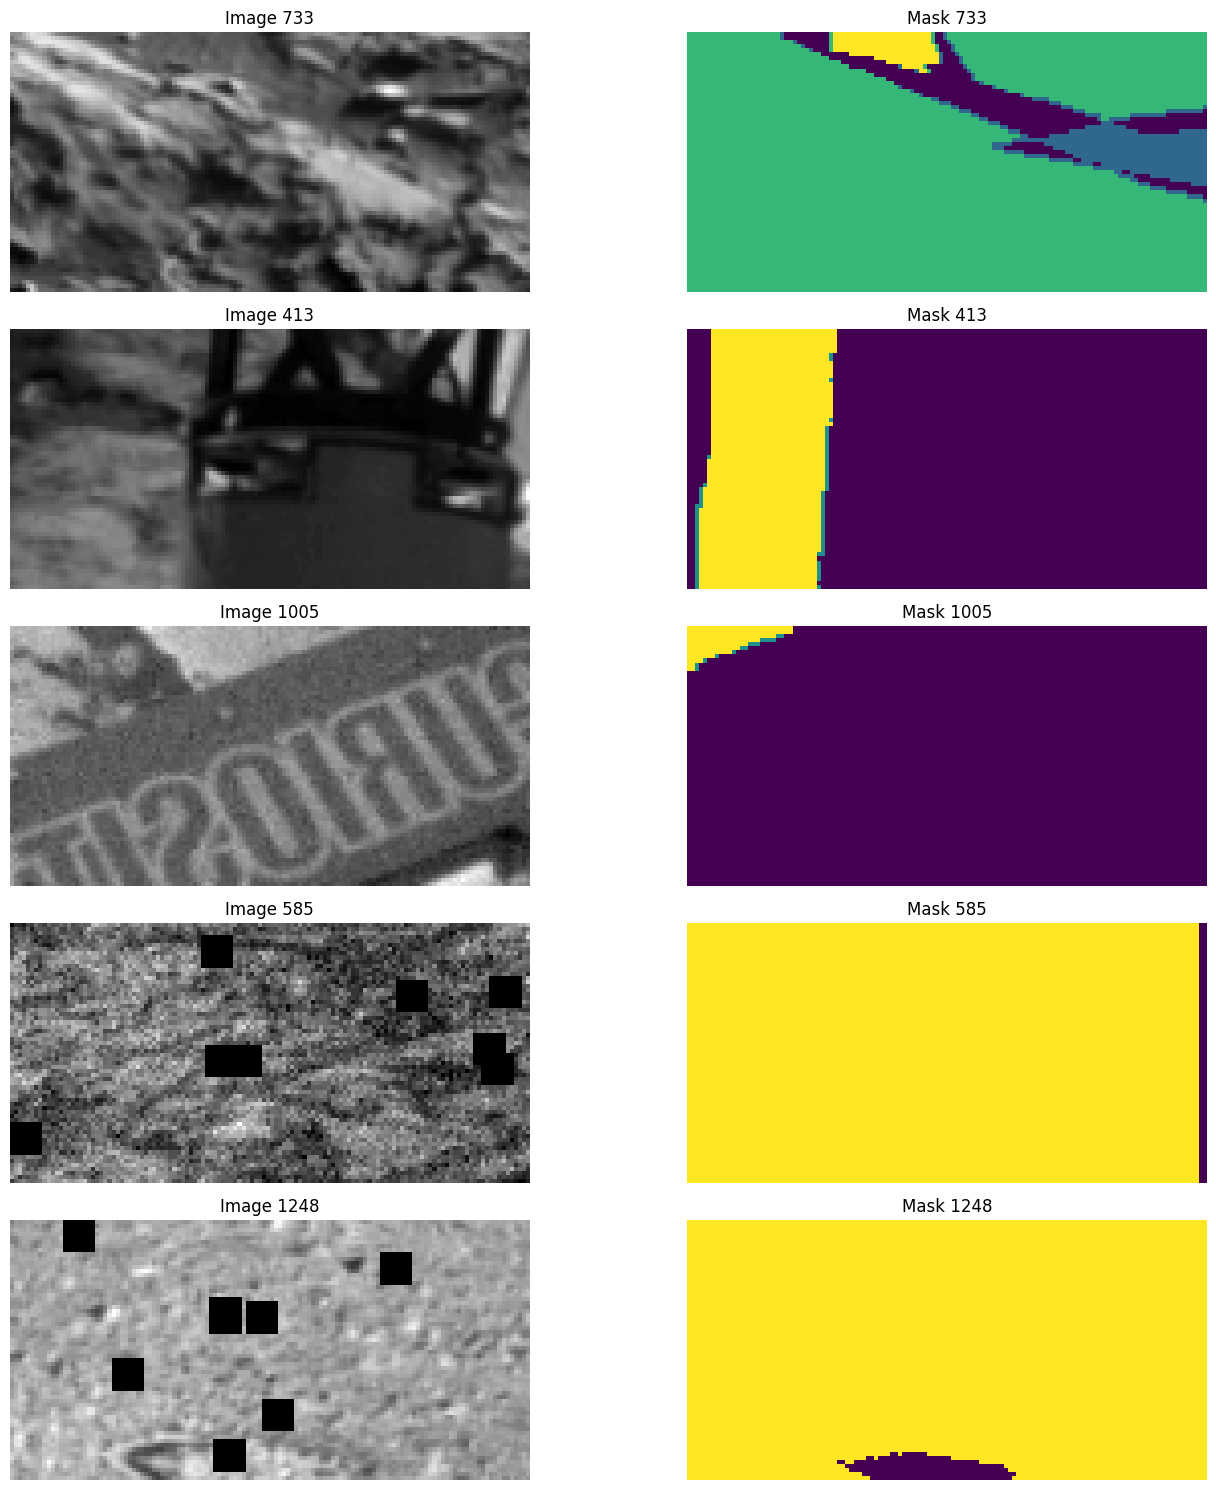

In [ ]:
# Example usage with augmented images and masks
plot_random_images(augmented_images, augmented_masks, num_images=5)

## 🛠️ Train and Save the Model

In [ ]:
# Add color channel and rescale pixels between 0 and 1
X_train = np.concatenate([X_train, augmented_images], axis=0)
y_train = np.concatenate([y_train, augmented_masks], axis=0)

X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0
y_train = y_train[..., np.newaxis]
# correction = correction[..., np.newaxis]
# X_train += correction
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:

# Residual Block
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add

def residual_block(x, filters):
    # Save the input value to add it later (skip connection)
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution layer
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Align shortcut dimensions to match x if necessary
    if shortcut.shape != x.shape:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)

    # Add shortcut to the output
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Encoder Block
def encoder_block(x, filters):
    x = residual_block(x, filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

# Decoder Block
def decoder_block(x, skip_features, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip_features])
    x = residual_block(x, filters)
    return x

# Build the Deep Residual U-Net Model
def build_residual_unet(input_shape, num_classes):
    inputs = layers.Input(input_shape)

    # Encoder
    x1, p1 = encoder_block(inputs, 64)
    x2, p2 = encoder_block(p1, 128)
    x3, p3 = encoder_block(p2, 256)
    x4, p4 = encoder_block(p3, 512)

    # Bottleneck (deepest layer)
    bottleneck = residual_block(p4, 1024)

    # Decoder
    x = decoder_block(bottleneck, x4, 512)
    x = decoder_block(x, x3, 256)
    x = decoder_block(x, x2, 128)
    x = decoder_block(x, x1, 64)

    # Output Layer
    outputs = layers.Conv2D(num_classes, 1, padding='same', activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Example with learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

unet_model = build_residual_unet(input_shape=(64, 128, 1), num_classes=5)  # Example for binary segmentation
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# Create the checkpoint callback to save every 50 epochs
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoint_epoch_{epoch:02d}.keras',  # Save file format with epoch number
    save_freq='epoch',  # Save at the end of every epoch
    save_best_only=False,  # Set to True if you only want to save the best model
    save_weights_only=False,  # Save the entire model (not just the weights)
    verbose=1  # Print a message when saving
)

# Define a custom callback to save every 50 epochs
class SaveEvery50Epochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 50 == 0:
            print(f"\nEpoch {epoch + 1}: Saving model checkpoint.")
            self.model.save(f'model_at_epoch_{epoch + 1}.h5')


# Use the generator in model training
unet_model.fit(X_train, y_train, batch_size=32, epochs=200, validation_split=0.2, callbacks=[SaveEvery50Epochs()])

Epoch 1/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 126s 552ms/step - accuracy: 0.4004 - loss: 1.3295 - val_accuracy: 0.1799 - val_loss: 3.3954
Epoch 2/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 66s 279ms/step - accuracy: 0.5205 - loss: 1.1105 - val_accuracy: 0.1795 - val_loss: 2.2504
Epoch 3/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 294ms/step - accuracy: 0.5783 - loss: 1.0179 - val_accuracy: 0.1975 - val_loss: 2.1642
Epoch 4/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 296ms/step - accuracy: 0.6058 - loss: 0.9677 - val_accuracy: 0.2662 - val_loss: 1.6880
Epoch 5/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 275ms/step - accuracy: 0.6279 - loss: 0.9241 - val_accuracy: 0.4042 - val_loss: 1.4832
Epoch 6/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 277ms/step - accuracy: 0.6448 - loss: 0.8826 - val_accuracy: 0.3752 - val_loss: 1.4235
Epoch 7/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 276ms/step - accuracy: 0.6630 - loss: 0.8481 - val_accuracy: 0.4895 - val_loss: 1.2243
Epoch 8/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.6804 


Epoch 50: Saving model checkpoint.
126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 488ms/step - accuracy: 0.9680 - loss: 0.0855 - val_accuracy: 0.7143 - val_loss: 1.4488
Epoch 51/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 58s 298ms/step - accuracy: 0.9707 - loss: 0.0782 - val_accuracy: 0.7054 - val_loss: 1.5800
Epoch 52/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 38s 273ms/step - accuracy: 0.9735 - loss: 0.0707 - val_accuracy: 0.7057 - val_loss: 1.5515
Epoch 53/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 275ms/step - accuracy: 0.9751 - loss: 0.0662 - val_accuracy: 0.7029 - val_loss: 1.5443
Epoch 54/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 277ms/step - accuracy: 0.9755 - loss: 0.0653 - val_accuracy: 0.7013 - val_loss: 1.3924
Epoch 55/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 276ms/step - accuracy: 0.9732 - loss: 0.0716 - val_accuracy: 0.6944 - val_loss: 1.5694
Epoch 56/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 276ms/step - accuracy: 0.9751 - loss: 0.0660 - val_accuracy: 0.7044 - val_loss: 1.4587
Epoch 57/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 


Epoch 100: Saving model checkpoint.
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 290ms/step - accuracy: 0.9913 - loss: 0.0222 - val_accuracy: 0.7134 - val_loss: 1.9245
Epoch 101/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 37s 296ms/step - accuracy: 0.9909 - loss: 0.0229 - val_accuracy: 0.7179 - val_loss: 1.9105
Epoch 102/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 295ms/step - accuracy: 0.9906 - loss: 0.0240 - val_accuracy: 0.7149 - val_loss: 2.0307
Epoch 103/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - accuracy: 0.9907 - loss: 0.0233 - val_accuracy: 0.7114 - val_loss: 2.1173
Epoch 104/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 286ms/step - accuracy: 0.9909 - loss: 0.0228 - val_accuracy: 0.7169 - val_loss: 1.9790
Epoch 105/200
117/126 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.9908 - loss: 0.0234

In [ ]:
import os
print(os.getcwd())  # Check the current directory
# Step 1: Load the saved model at epoch 50
unet_model = tf.keras.models.load_model('model_at_epoch_100.h5')


/gdrive/.shortcut-targets-by-id/1vsTygZGT_kAzNeU8X79sw_R-6RcOwzqm/Homework 2


In [ ]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
unet_model.save(model_filename)



print(f"Model saved to {model_filename}")

Model saved to model_241214_180152.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [ ]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [ ]:
#preds = unet_model.predict(X_test)
preds = unet_model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step
Predictions shape: (10022, 64, 128)


In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

#from docker send the file to the output folder in the host
print(f"Submission saved to {submission_filename}")


Submission saved to submission_241214_180152.csv


In [ ]:
from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  
<img src="https://airlab.deib.polimi.it/wp-content/uploads/2019/07/airlab-logo-new_cropped.png" width="350">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Instagram_logo_2022.svg/800px-Instagram_logo_2022.svg.png" width="15"> **Instagram:** https://www.instagram.com/airlab_polimi/

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/LinkedIn_icon.svg/2048px-LinkedIn_icon.svg.png" width="15"> **LinkedIn:** https://www.linkedin.com/company/airlab-polimi/
___
Credits: Alberto Archetti 📧 alberto.archetti@polito.it





```
   Copyright 2024 Alberto Archetti

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
```